# ***Version 06***
  - v06: Added Grad-CAM for Xception,EfficientNet and Added Attention Rollout for ViT
  - v05: Changed Dataset. Train, Test, Evaluate, Visalization Done
  - v04: Added one more Model (ViT), Removed Grad-CAM++ function
  - v03: Added Grad-CAM and Grad-CAM++ (eXplainable AI) for XceptionNet
  - v02: Added Data Augmentation to prevent overfitting
  - v01: Initial base model
---




*   Topic:
    Deepfake Detection with Images
*   Models:
    XceptionNet, EfficientNet-B0, ViT
*   Developement Environment:
  1.   Google Colab
  2.   Tesla T4 GPU
  3.   PyTorch
*   Dataset: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
*   Research Questions
  1.   How does the architectural difference between EfficientNet-B0 and XceptionNet influence their performance in detecting deepfake images?
  2.   Which model, EfficientNet-B0 or XceptionNet, demonstrates higher accuracy and computational efficiency in detecting deepfake images?
  3.   How does data augmentation impact the performance of deepfake image detection models trained on imbalanced datasets?
  4.   How do the Grad-CAM visualizations of each model, as an Explainable AI (XAI) technique, differ in terms of feature extraction for deepfake detection?
  






# 1. Install Packages

In [ ]:
!pip install efficientnet_pytorch # For EfficientNet
!pip install timm # For XceptionNet
!pip install torch torchvision matplotlib numpy # For grad-CAM
!pip install grad-cam  # For Grad-CAM

# 2. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import timm
import matplotlib.pyplot as plt
import os
import shutil
import random
import time
import seaborn as sns
import numpy as np
import cv2
import pandas as pd
import json
import joblib

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from glob import glob
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc
from google.colab import drive
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


# 3. Drive Mount

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 4. Prepare Models (XceptionNet, EfficientNet-B0 and ViT)

In [ ]:
# XceptionNet
model_xception = timm.create_model('xception', pretrained=True, num_classes=2)

# EfficientNet-B0
model_efficient = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)

# pretrained ViT model
model_vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=2, ignore_mismatched_sizes=True)

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Split the data into 80% training, 10% validation and 10% test

In [ ]:
# # Path for image folder
# base_dir = '/content/drive/MyDrive/datasets/deepfake'
# output_dir = '/content/drive/MyDrive/datasets/deepfake/split_dataset'

# # Split fake/real dataset
# classes = ['Real', 'Fake']
# train_ratio = 0.8
# validation_ratio = 0.1

# for cls in classes:
#     img_paths = glob(os.path.join(base_dir, cls, '*'))
#     total_count = len(img_paths)
#     random.shuffle(img_paths)

#     train_end = int(total_count * train_ratio)
#     validation_end = train_end + int(total_count * validation_ratio)

#     train_imgs = img_paths[:train_end]
#     validation_imgs = img_paths[train_end:validation_end]
#     test_imgs = img_paths[validation_end:]

#     # make directory
#     for phase in ['train', 'validation', 'test']:
#         target_dir = os.path.join(output_dir, phase, cls)
#         os.makedirs(target_dir, exist_ok=True)

#     # copy images
#     for img_path in train_imgs:
#         shutil.copy(img_path, os.path.join(output_dir, 'train', cls))

#     for img_path in validation_imgs:
#         shutil.copy(img_path, os.path.join(output_dir, 'validation', cls))

#     for img_path in test_imgs:
#         shutil.copy(img_path, os.path.join(output_dir, 'test', cls))

#     # print the number of images after splitting
#     print(f"[{cls}] Total number of images: {total_count}")
#     print(f"[{cls}] Number of training images: {len(train_imgs)}")
#     print(f"[{cls}] Number of validation images: {len(validation_imgs)}")
#     print(f"[{cls}] Number of test images: {len(test_imgs)}")
#     print('-' * 40)

# print("Image split and copy completed.")


KeyboardInterrupt: 

# 6. Dataset Preprocessing and Loading

In [ ]:
# ---------------  XceptionNet, EfficientNet-B0  ---------------
# Data Augmentation (to prevent overfitting)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),     # Horizontal flip
    transforms.RandomRotation(20),         # Random rotation within 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color properties
    transforms.RandomResizedCrop(224),     # Random crop and resize to 224x224
    transforms.ToTensor(),                 # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with mean and std
])


# ---------------  ViT  ---------------
# Load feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
# Custom transform using ViT feature extractor
class ViTTransform:
    def __call__(self, image):
        encoding = feature_extractor(images=image, return_tensors="pt")
        return encoding['pixel_values'].squeeze(0)

transform_vit = ViTTransform()


train_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/split_dataset/train', transform=transform)
validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/split_dataset/validation', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/split_dataset/test', transform=transform)

train_dataset_vit = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/split_dataset/train', transform=transform_vit)
validation_dataset_vit = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/split_dataset/validation', transform=transform_vit)
test_dataset_vit = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/split_dataset/test', transform=transform_vit)

# train_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/test_YJ/train', transform=transform)
# validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/test_YJ/validation', transform=transform)
# test_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/test_YJ/test', transform=transform)

# train_dataset_vit = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/test_YJ/train', transform=transform_vit)
# validation_dataset_vit = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/test_YJ/validation', transform=transform_vit)
# test_dataset_vit = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/test_YJ/test', transform=transform_vit)

dataset = ImageFolder(root='/content/drive/MyDrive/datasets/deepfake/split_dataset/test')
print(dataset.class_to_idx)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

train_loader_vit = DataLoader(train_dataset_vit, batch_size=16, shuffle=True, num_workers=2)
validation_loader_vit = DataLoader(validation_dataset_vit, batch_size=32, shuffle=False, num_workers=2)
test_loader_vit = DataLoader(test_dataset_vit, batch_size=32, shuffle=False, num_workers=2)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


{'Fake': 0, 'Real': 1}


# 7. Define Grad-CAM - 지금 버전에서는 안써.

In [ ]:
# class GradCAM:
#     def __init__(self, model, target_layer):
#         self.model = model
#         self.target_layer = target_layer
#         self.gradients = None
#         self.activations = None

#     def register_hooks(self):
#         def forward_hook(module, input, output):
#             self.activations = output.detach()

#         def backward_hook(module, grad_input, grad_output):
#             self.gradients = grad_output[0].detach()

#         self.target_layer.register_forward_hook(forward_hook)
#         self.target_layer.register_full_backward_hook(backward_hook)

#     def generate_cam(self, input_tensor, class_idx):
#         self.model.zero_grad()
#         output = self.model(input_tensor)
#         target = output[:, class_idx].sum()
#         target.backward()

#         weights = self.gradients.mean(dim=(2, 3), keepdim=True)
#         cam = (weights * self.activations).sum(dim=1, keepdim=True)
#         cam = F.relu(cam)

#         cam = cam.squeeze().cpu().numpy()
#         cam = (cam - cam.min()) / (cam.max() + 1e-6)  # Normalize
#         cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
#         return cam

#     def visualize_cam(self, input_tensor, cam):
#         # Convert input tensor to numpy image
#         img_tensor = input_tensor[0].cpu().permute(1, 2, 0).detach().numpy()
#         img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min() + 1e-8)
#         img_np = np.clip(img_tensor, 0, 1)

#         # Normalize CAM
#         cam = cam - np.min(cam)
#         cam = cam / (np.max(cam) + 1e-8)

#         # If cam has more than 1 channel, select one (e.g., first channel or average)
#         if cam.ndim == 3 and cam.shape[2] == 7:
#             cam = np.mean(cam, axis=-1)  # Average across channels (or use cam[:, :, 0] for first channel)

#         # Convert to uint8
#         cam_uint8 = np.uint8(255 * cam)

#         # Apply heatmap
#         heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
#         heatmap = np.float32(heatmap) / 255

#         # Resize heatmap if necessary
#         if heatmap.shape[:2] != img_np.shape[:2]:
#             heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))

#         # Superimpose
#         superimposed_img = heatmap + img_np
#         superimposed_img = superimposed_img / np.max(superimposed_img)
#         return superimposed_img





# 8. Define the training function

In [ ]:

def train_model(model, train_loader, validation_loader, epochs=10, model_name=''):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Metrics tracking
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    train_precisions, train_recalls, train_f1s, train_aucs = [], [], [], []
    val_precisions, val_recalls, val_f1s, val_aucs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0
        all_train_preds, all_train_labels = [], []

        for batch in train_loader:
            # Handle ViT or CNN input
            if isinstance(batch, dict):
                images = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)
            else:
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            if hasattr(outputs, "logits"):  # For ViT models
                outputs = outputs.logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            all_train_preds.extend(outputs.argmax(1).cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_accuracy = correct / len(train_loader.dataset)
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        train_auc = roc_auc_score(all_train_labels, all_train_preds, multi_class='ovo')

        # --- Validation ---
        model.eval()
        val_loss, val_correct = 0.0, 0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for batch in validation_loader:
                if isinstance(batch, dict):
                    images = batch["pixel_values"].to(device)
                    labels = batch["labels"].to(device)
                else:
                    images, labels = batch
                    images = images.to(device)
                    labels = labels.to(device)

                outputs = model(images)
                if hasattr(outputs, "logits"):  # For ViT models
                    outputs = outputs.logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                all_val_preds.extend(outputs.argmax(1).cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_accuracy = val_correct / len(validation_loader.dataset)
        val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
        val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_auc = roc_auc_score(all_val_labels, all_val_preds, multi_class='ovo')

        # Save metrics
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss / len(validation_loader))
        val_accuracies.append(val_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        train_aucs.append(train_auc)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)

        print(f"[Epoch {epoch+1}] Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    # Save model weights after training
    if model_name:
        save_model_dir = "/content/drive/MyDrive/UE/Thesis/model"
        os.makedirs(save_model_dir, exist_ok=True)
        weights_path = os.path.join(save_model_dir, f"{model_name}_weights.pth")
        metadata_path = os.path.join(save_model_dir, f"{model_name}_metadata.pkl")
        torch.save(model.state_dict(), weights_path)
        metadata = {"class_names": ["Fake", "Real"]}
        joblib.dump(metadata, metadata_path)
        print(f"Model saved to {weights_path}")
        print(f"Metadata saved to {metadata_path}")

    # Call your metric plotting function
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                 train_precisions, val_precisions,
                 train_recalls, val_recalls,
                 train_f1s, val_f1s,
                 train_aucs, val_aucs, model_name)


# 9. Define the evaluation fuction - 지금 버전에서는 안써. grad-cam 오류때문에

In [ ]:
# def evaluate_model(model, dataloader):

#     ######################### GPU 버전에서 이부분 추가
#     #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     model.eval()
#     y_true = []
#     y_pred = []
#     y_probs = []  # Store probabilities for ROC curve

#     device = torch.device("cpu")  # 모델을 CPU로 설정


#     model = model.to(device)


#     grad_cam = GradCAM(model, model.conv4.pointwise)  # Xception last conv layer
#     grad_cam.register_hooks()


#     ########### CPU로 할때는 with torch.no_grad() 주석처리하고 바로아래 for문 땡겨서 테스트. GPU로 하면 with 주석 풀고 for 문 그 안에 넣어야돼
#     #with torch.no_grad():
#     for images, labels in dataloader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)

#         # Convert logits to probabilities
#         probs = F.softmax(outputs, dim=1)
#         preds = outputs.argmax(1).cpu()

#         y_pred.extend(preds.numpy())
#         y_true.extend(labels.numpy())


#         y_probs.extend(probs[:, 1].detach().cpu().numpy())
#         ################## CPU로 테스트할땐 위에꺼로, GPU로 하면 아래
#         #y_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class '1' (AI)


#         ###################### GPU 버전에서는 이거 제거.
#         model = model.to(device)  # 모델을 CPU로 이동

#         # Grad-CAM for AI class
#         grad_cam_ai = GradCAM(model, model.conv4.pointwise)  # Xception last conv layer
#         grad_cam_ai.register_hooks()
#         cam_ai = grad_cam_ai.generate_cam(images, class_idx=1)  # AI class (index 1)
#         superimposed_img_ai = grad_cam_ai.visualize_cam(images, cam_ai)

#         plt.imshow(superimposed_img_ai)
#         plt.axis('off')
#         plt.title(f"AI Class Grad-CAM (Probability: {probs[0][1]:.4f})")
#         plt.show()

#         # Grad-CAM for real class
#         grad_cam_real = GradCAM(model, model.conv4.pointwise)
#         grad_cam_real.register_hooks()
#         cam_real = grad_cam_real.generate_cam(images, class_idx=0)  # Real class (index 0)
#         superimposed_img_real = grad_cam_real.visualize_cam(images, cam_real)

#         plt.imshow(superimposed_img_real)
#         plt.axis('off')
#         plt.title(f"Real Class Grad-CAM (Probability: {probs[0][0]:.4f})")
#         plt.show()

#         # Grad-CAM for predicted class
#         grad_cam = GradCAM(model, model.conv4.pointwise)
#         grad_cam.register_hooks()
#         cam = grad_cam.generate_cam(images, class_idx=preds[0].item())
#         superimposed_img = grad_cam.visualize_cam(images, cam)

#         plt.imshow(superimposed_img)
#         plt.axis('off')
#         plt.title(f"Predicted: {preds[0].item()}, AI Probability: {probs[0][1]:.4f}")
#         plt.show()




#     # Print classification report (precision, recall, F1-score)
#     print(classification_report(y_true, y_pred, target_names=['real', 'AI']))

#     # Plot Confusion Matrix
#     cm = confusion_matrix(y_true, y_pred)
#     plt.figure(figsize=(5, 4))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'AI'], yticklabels=['real', 'AI'])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title('Confusion Matrix')
#     plt.show()

#     # Plot ROC Curve
#     fpr, tpr, _ = roc_curve(y_true, y_probs)
#     roc_auc = auc(fpr, tpr)
#     plt.figure()
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
#     plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal reference line
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend(loc="lower right")
#     plt.grid(True)
#     plt.show()


# 9. Define the evaluation fuction (without Grad-CAM)

In [ ]:
def evaluate_model(model, dataloader, model_name):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    y_true = []
    y_pred = []
    y_probs = []  # Store probabilities for ROC curve

    with torch.no_grad():
        for batch in dataloader:
            # ViT-style: dict with 'pixel_values' and 'labels'
            if isinstance(batch, dict):
                images = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)
            else:
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)

            outputs = model(images)

            # Handle HuggingFace ViT output format
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(1).cpu()

            y_pred.extend(preds.numpy())
            y_true.extend(labels.cpu().numpy())
            y_probs.extend(probs[:, 0].detach().cpu().numpy())  # For binary class 1 . Fake



    # Classification report
    print(f"{model_name} Classification Report:\n{classification_report(y_true, y_pred, target_names=['Fake','Real'])}")

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=['Fake','Real'], output_dict=True, zero_division=0)

    # Save metrics as json file
    save_dir = "/content/drive/MyDrive/UE/Thesis"
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, f"{model_name}_metrics.json"), "w") as f:
        json.dump(report, f, indent=4)
    print(f"Saved: {save_dir}/{model_name}_metrics.json")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(os.path.join(save_dir, f"{model_name}_Confusion_Matrix.pdf"), format='pdf')
    print(f"Saved: {save_dir}/{model_name}_Confusion_Matrix.pdf")
    plt.show()
    plt.close()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_probs, pos_label=0)  # pos_label=0 - class 0(Fake)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, f"{model_name}_ROC_Curve.pdf"), format='pdf')
    print(f"Saved: {save_dir}/{model_name}_ROC_Curve.pdf")
    plt.show()
    plt.close()


# 10.Define Make metrics/graphs

In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                 train_precisions, val_precisions,
                 train_recalls, val_recalls,
                 train_f1s, val_f1s,
                 train_aucs, val_aucs, model_name):
    # Loss
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(3, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(3, 2, 3)
    plt.plot(train_precisions, label='Train')
    plt.plot(val_precisions, label='Validation')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(3, 2, 4)
    plt.plot(train_recalls, label='Train')
    plt.plot(val_recalls, label='Validation')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # F1-Score
    plt.subplot(3, 2, 5)
    plt.plot(train_f1s, label='Train')
    plt.plot(val_f1s, label='Validation')
    plt.title('F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    # AUC
    plt.subplot(3, 2, 6)
    plt.plot(train_aucs, label='Train')
    plt.plot(val_aucs, label='Validation')
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.tight_layout()

    save_dir = "/content/drive/MyDrive/UE/Thesis"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{model_name}_Metrics_per_Epoch.pdf"), format='pdf')
    print(f"Saved: {save_dir}/{model_name}_Metrics_per_Epoch.pdf")

    plt.show()
    plt.close()

# 11. Set up device (GPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 12-1. Train XceptionNet

Training XceptionNet...
----------------------------------------
[Epoch 1] Train Acc: 0.8185, Val Acc: 0.8781
[Epoch 2] Train Acc: 0.8776, Val Acc: 0.8753
[Epoch 3] Train Acc: 0.9008, Val Acc: 0.8955
[Epoch 4] Train Acc: 0.9026, Val Acc: 0.8937
[Epoch 5] Train Acc: 0.9139, Val Acc: 0.9111
[Epoch 6] Train Acc: 0.9201, Val Acc: 0.9056
[Epoch 7] Train Acc: 0.9258, Val Acc: 0.9093
[Epoch 8] Train Acc: 0.9260, Val Acc: 0.9129
[Epoch 9] Train Acc: 0.9370, Val Acc: 0.9010
[Epoch 10] Train Acc: 0.9384, Val Acc: 0.9102
Model saved to /content/drive/MyDrive/UE/Thesis/model/Xception_weights.pth
Metadata saved to /content/drive/MyDrive/UE/Thesis/model/Xception_metadata.pkl
Saved: /content/drive/MyDrive/UE/Thesis/Xception_Metrics_per_Epoch.pdf


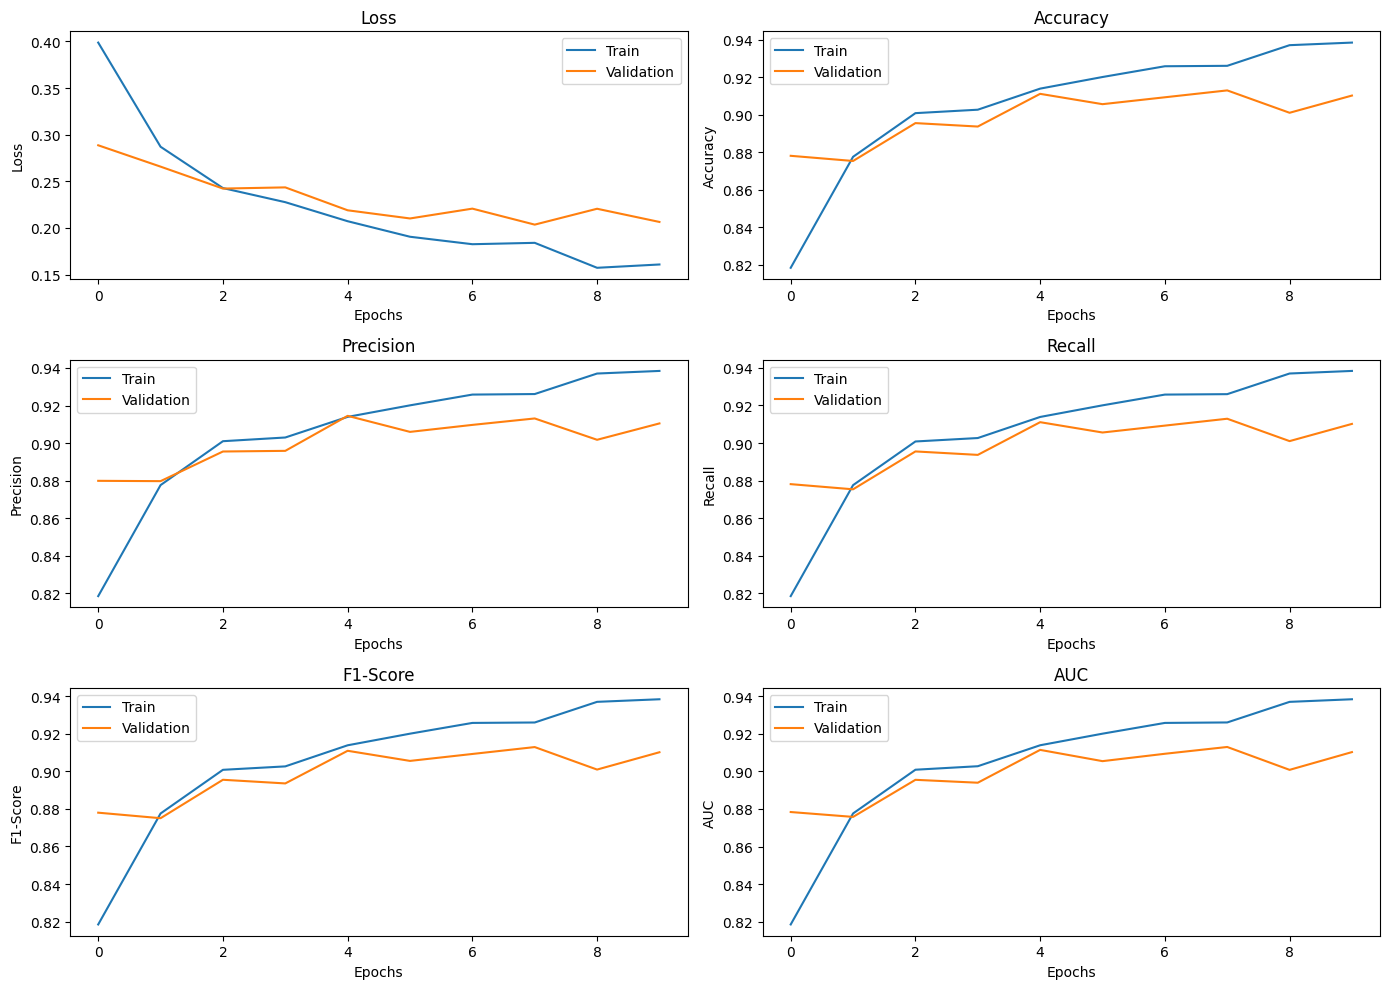

Training completed in 46.86 minutes


In [ ]:
print("Training XceptionNet...")
print('-' * 40)
start_time = time.time()

train_model(model_xception, train_loader, validation_loader, epochs=10, model_name='Xception')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time / 60:.2f} minutes")

# 12-2. Evaluate XceptionNet

Xception Classification Report:
              precision    recall  f1-score   support

        Fake       0.91      0.91      0.91       551
        Real       0.91      0.91      0.91       542

    accuracy                           0.91      1093
   macro avg       0.91      0.91      0.91      1093
weighted avg       0.91      0.91      0.91      1093

Saved: /content/drive/MyDrive/UE/Thesis/Xception_metrics.json
Saved: /content/drive/MyDrive/UE/Thesis/Xception_Confusion_Matrix.pdf


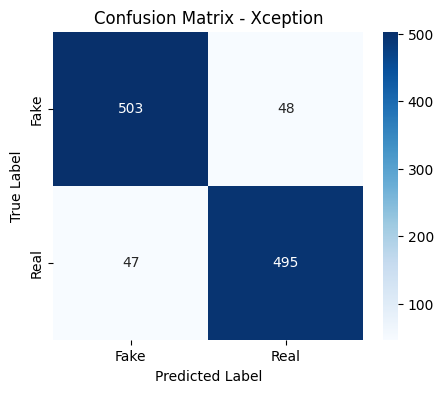

Saved: /content/drive/MyDrive/UE/Thesis/Xception_ROC_Curve.pdf


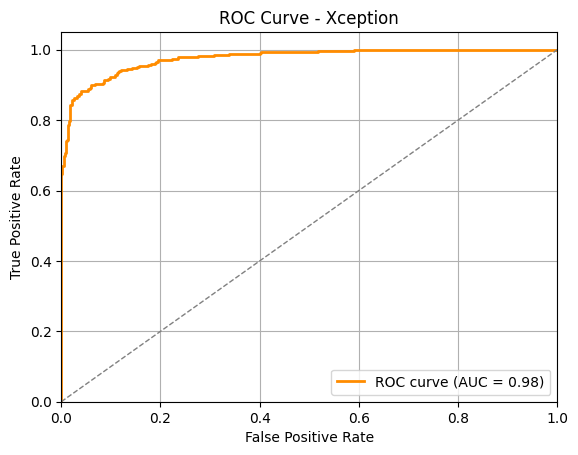

In [ ]:
#print(model_xception)

evaluate_model(model_xception, test_loader, "Xception")

# 13-1. Train EfficientNet-B0

Training EfficientNet-B0...
----------------------------------------
[Epoch 1] Train Acc: 0.7540, Val Acc: 0.7736
[Epoch 2] Train Acc: 0.7909, Val Acc: 0.7727
[Epoch 3] Train Acc: 0.8249, Val Acc: 0.8139
[Epoch 4] Train Acc: 0.8477, Val Acc: 0.8515
[Epoch 5] Train Acc: 0.8640, Val Acc: 0.8433
[Epoch 6] Train Acc: 0.8714, Val Acc: 0.8662
[Epoch 7] Train Acc: 0.8863, Val Acc: 0.8845
[Epoch 8] Train Acc: 0.8953, Val Acc: 0.8808
[Epoch 9] Train Acc: 0.8970, Val Acc: 0.8753
[Epoch 10] Train Acc: 0.9010, Val Acc: 0.8863
Model saved to /content/drive/MyDrive/UE/Thesis/model/EfficientNet_weights.pth
Metadata saved to /content/drive/MyDrive/UE/Thesis/model/EfficientNet_metadata.pkl
Saved: /content/drive/MyDrive/UE/Thesis/EfficientNet_Metrics_per_Epoch.pdf


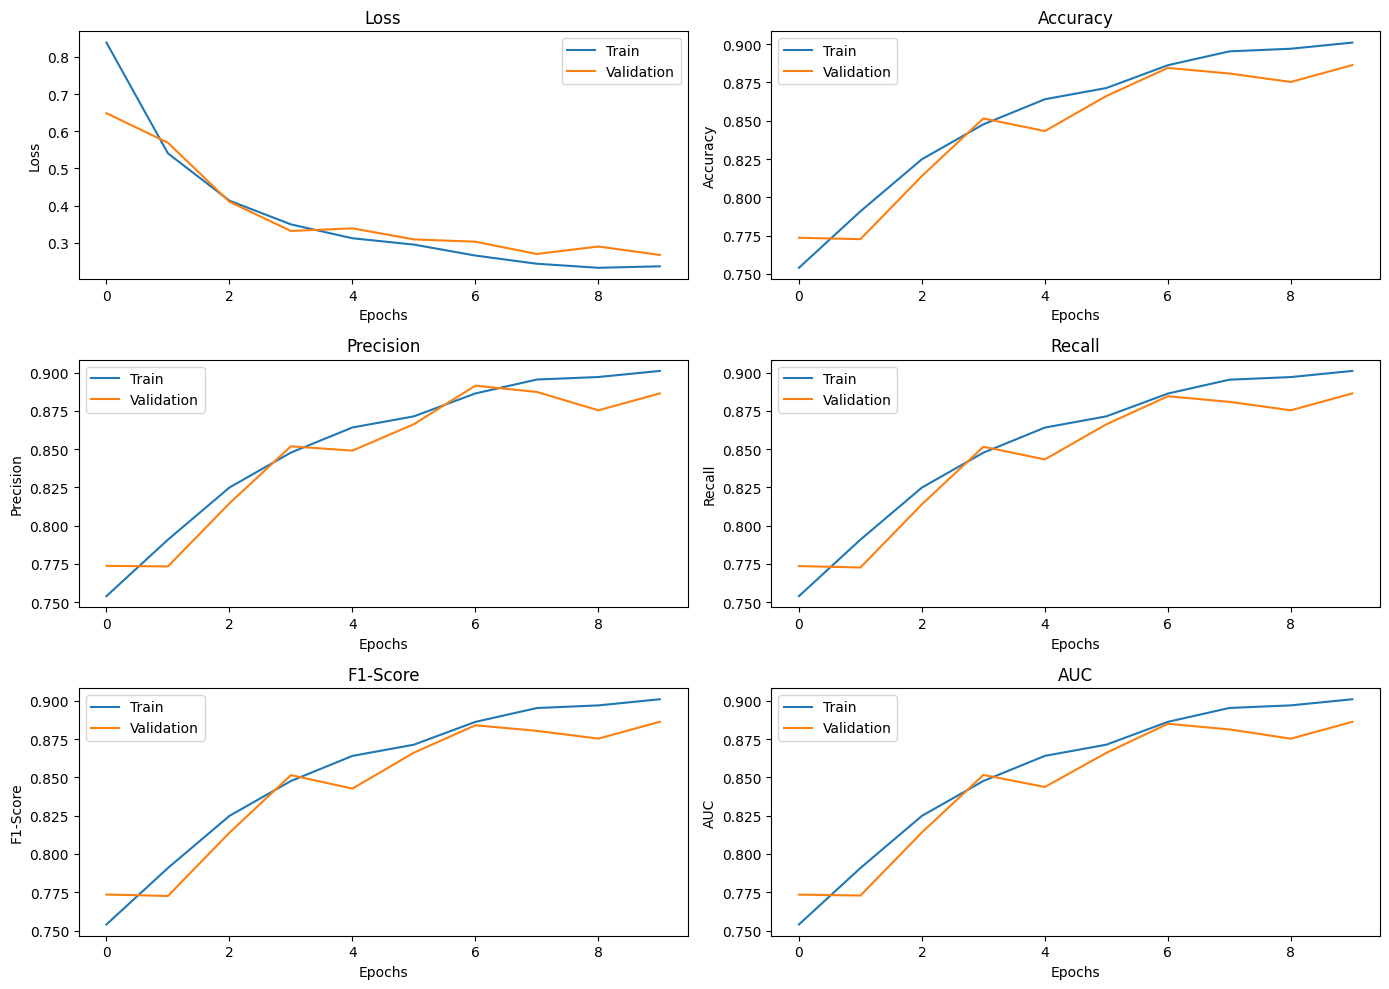

Training completed in 21.59 minutes


In [ ]:
print("Training EfficientNet-B0...")
print('-' * 40)
start_time = time.time()

train_model(model_efficient, train_loader, validation_loader, epochs=10, model_name='EfficientNet')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time / 60:.2f} minutes")



# 13-2. Evaluate EfficientNet-B0

EfficientNet Classification Report:
              precision    recall  f1-score   support

        Fake       0.87      0.91      0.89       551
        Real       0.91      0.87      0.89       542

    accuracy                           0.89      1093
   macro avg       0.89      0.89      0.89      1093
weighted avg       0.89      0.89      0.89      1093

Saved: /content/drive/MyDrive/UE/Thesis/EfficientNet_metrics.json
Saved: /content/drive/MyDrive/UE/Thesis/EfficientNet_Confusion_Matrix.pdf


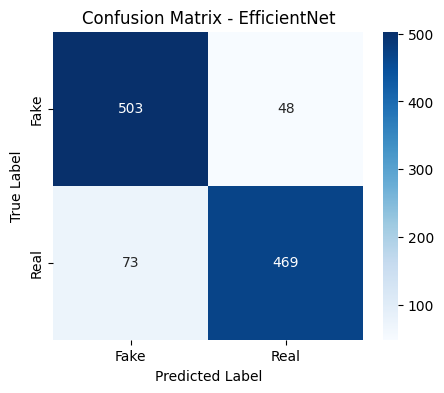

Saved: /content/drive/MyDrive/UE/Thesis/EfficientNet_ROC_Curve.pdf


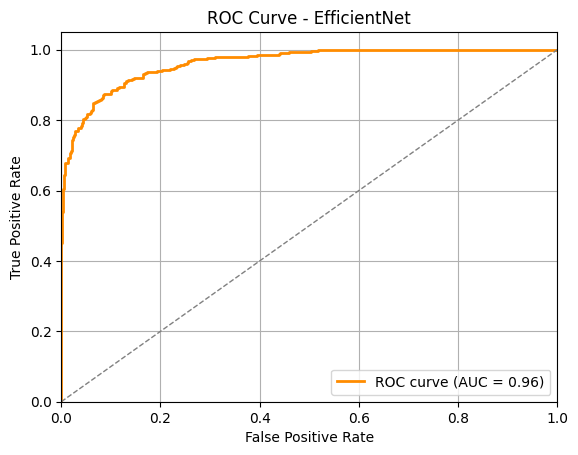

In [ ]:
#print(model_efficient)

evaluate_model(model_efficient, test_loader, "EfficientNet")

# 14-1. Train ViT

Training ViT...
----------------------------------------
[Epoch 1] Train Acc: 0.8917, Val Acc: 0.9166
[Epoch 2] Train Acc: 0.9683, Val Acc: 0.9377
[Epoch 3] Train Acc: 0.9804, Val Acc: 0.9386
[Epoch 4] Train Acc: 0.9849, Val Acc: 0.9368
[Epoch 5] Train Acc: 0.9865, Val Acc: 0.9395
[Epoch 6] Train Acc: 0.9907, Val Acc: 0.9459
[Epoch 7] Train Acc: 0.9916, Val Acc: 0.9368
[Epoch 8] Train Acc: 0.9934, Val Acc: 0.9423
[Epoch 9] Train Acc: 0.9932, Val Acc: 0.9395
[Epoch 10] Train Acc: 0.9927, Val Acc: 0.9248
Model saved to /content/drive/MyDrive/UE/Thesis/model/ViT_weights.pth
Metadata saved to /content/drive/MyDrive/UE/Thesis/model/ViT_metadata.pkl
Saved: /content/drive/MyDrive/UE/Thesis/ViT_Metrics_per_Epoch.pdf


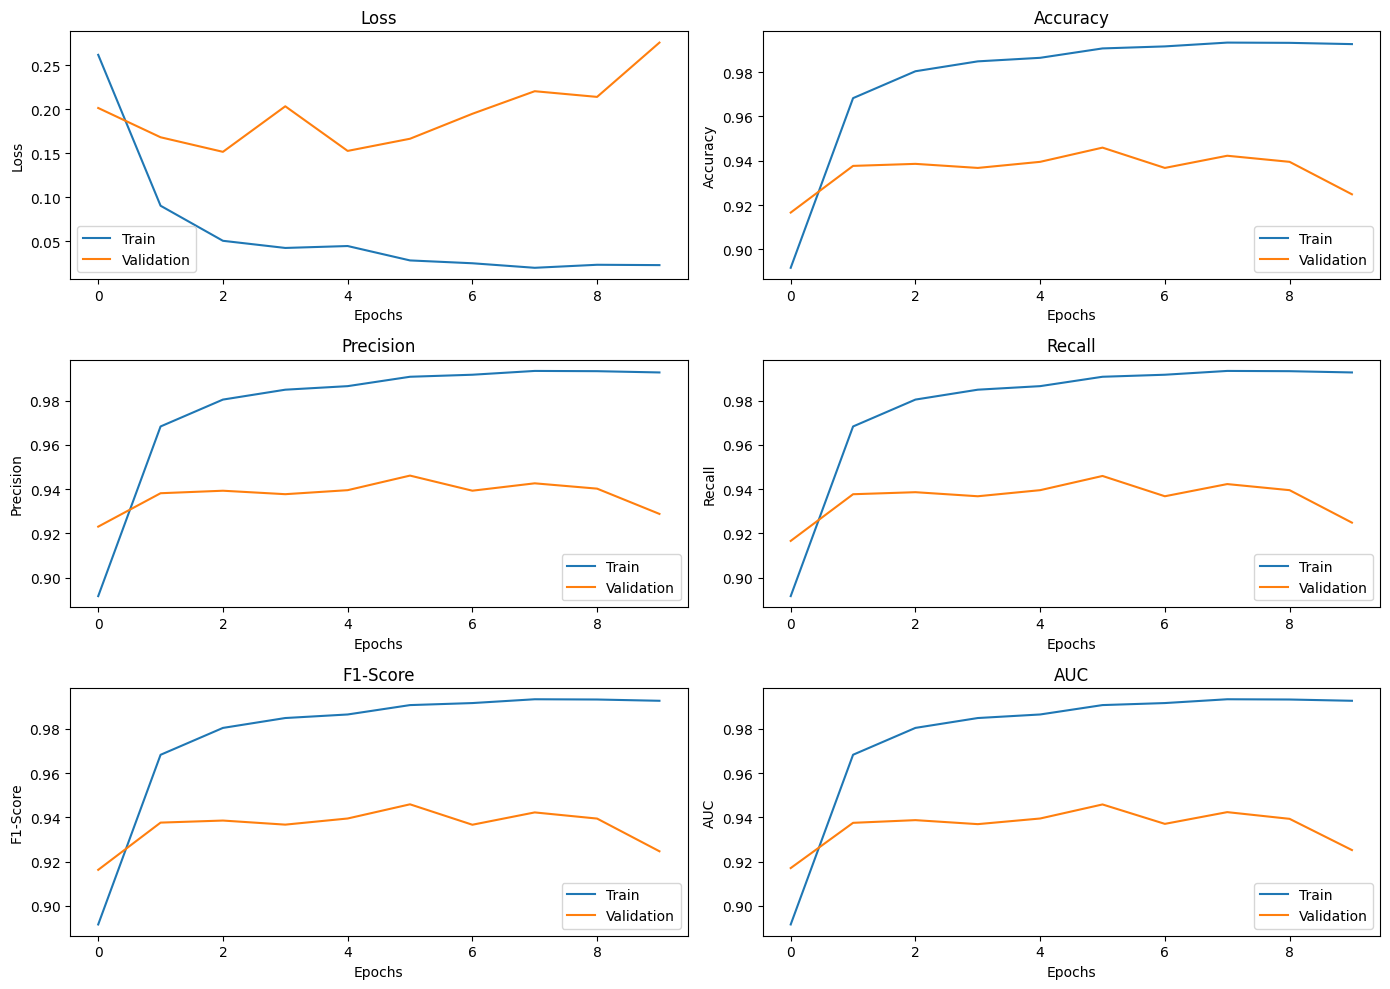

Training completed in 51.69 minutes


In [ ]:
print("Training ViT...")
print('-' * 40)
start_time = time.time()

train_model(model_vit, train_loader_vit, validation_loader_vit, epochs=10, model_name='ViT')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time / 60:.2f} minutes")

# 14-2. Evaluate ViT

ViT Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      0.90      0.94       551
        Real       0.90      0.98      0.94       542

    accuracy                           0.94      1093
   macro avg       0.94      0.94      0.94      1093
weighted avg       0.94      0.94      0.94      1093

Saved: /content/drive/MyDrive/UE/Thesis/ViT_metrics.json
Saved: /content/drive/MyDrive/UE/Thesis/ViT_Confusion_Matrix.pdf


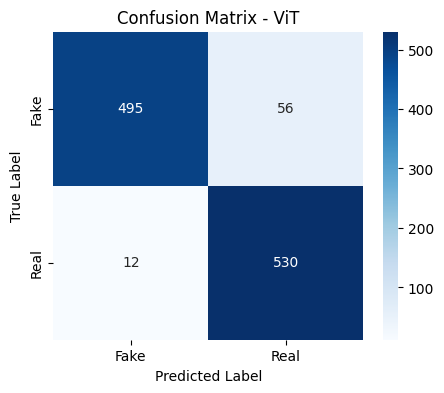

Saved: /content/drive/MyDrive/UE/Thesis/ViT_ROC_Curve.pdf


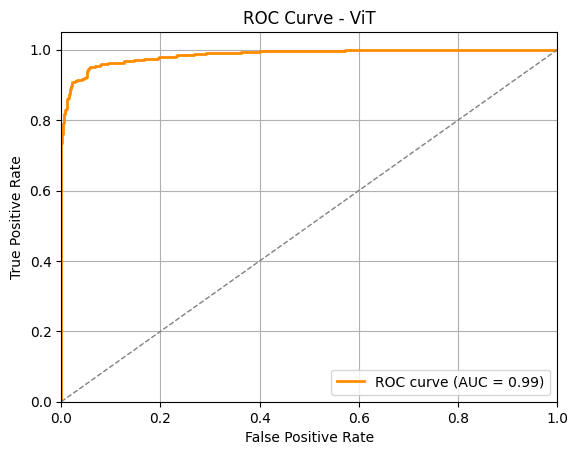

In [ ]:
#print(model_vit)

evaluate_model(model_vit, test_loader_vit, "ViT")

# 15. Compare 3 Models

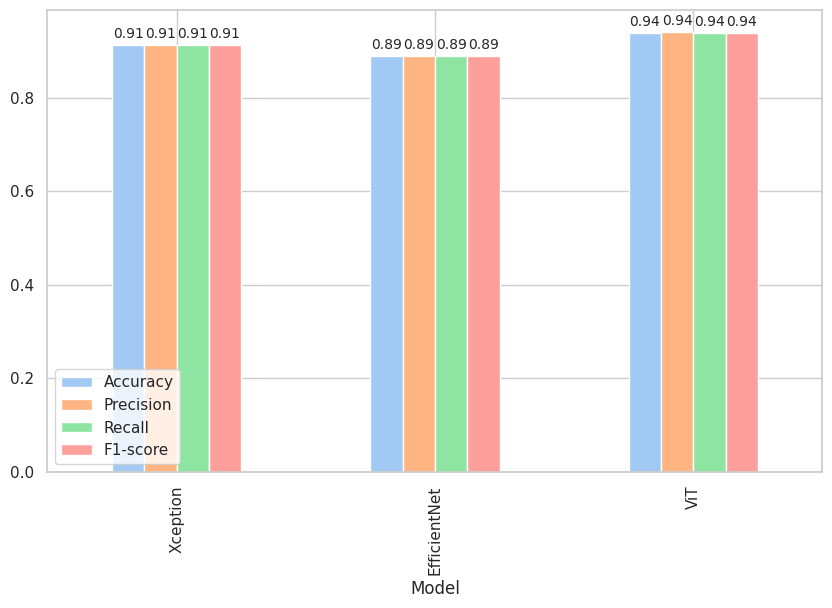

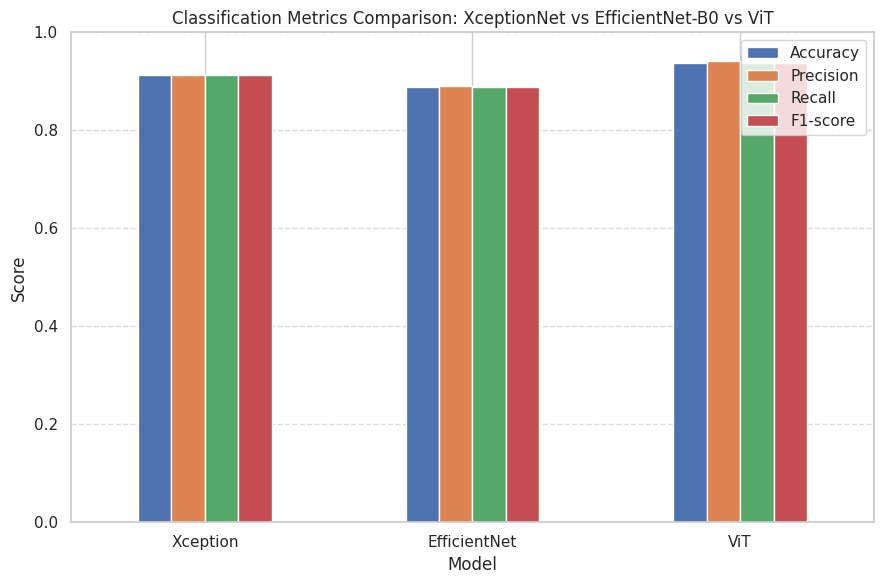

In [ ]:
# Models
model_names = ["Xception", "EfficientNet", "ViT"]

# metrics list
metrics_data = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}

# Update this to match your save path
metrics_dir = "/content/drive/MyDrive/UE/Thesis"

# Load metrics
for model in model_names:
    file_path = os.path.join(metrics_dir, f"{model}_metrics.json")
    with open(file_path, "r") as f:
        report = json.load(f)

    metrics_data["Model"].append(model)
    metrics_data["Accuracy"].append(report["accuracy"])
    metrics_data["Precision"].append(report["weighted avg"]["precision"])
    metrics_data["Recall"].append(report["weighted avg"]["recall"])
    metrics_data["F1-score"].append(report["weighted avg"]["f1-score"])

# DataFrame
df = pd.DataFrame(metrics_data)

# Visualization
df.plot(kind='bar', x='Model', figsize=(9,6),
        title="Classification Metrics Comparison: XceptionNet vs EfficientNet-B0 vs ViT")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(metrics_dir, "Model_Comparison_Plot.pdf"), format='pdf')
plt.show()
plt.close()


# Grad-CAM (XceptionNet) - TEST

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


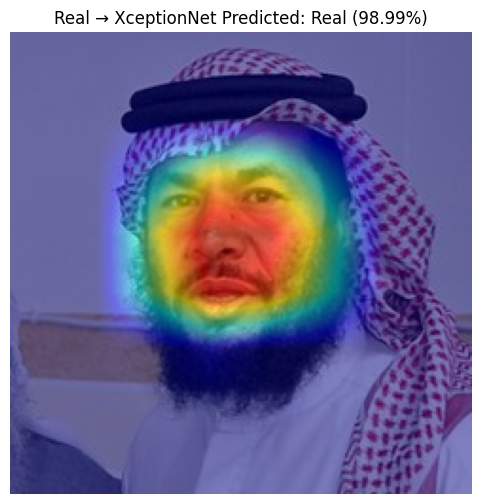

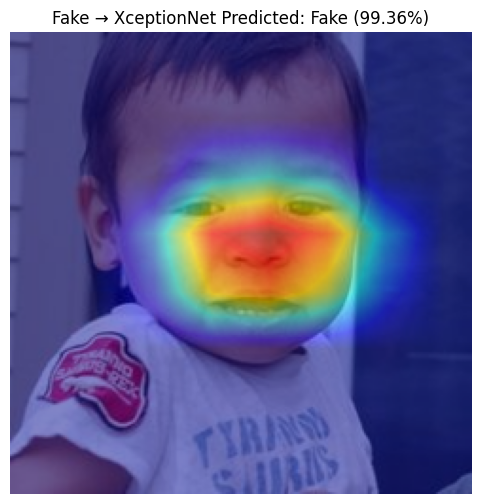

In [ ]:
# Define base directory
base_dir = "/content/drive/MyDrive/"

# Load metadata
metadata = joblib.load(os.path.join(base_dir, "UE/Thesis/model/Xception_metadata.pkl"))
class_names = metadata.get("class_names", ["Fake", "Real"])
input_size = metadata.get("input_size", (244, 244))

# Load Xception model and weights
model = timm.create_model("xception", pretrained=False, num_classes=len(class_names))
weights_path = os.path.join(base_dir, "UE/Thesis/model/Xception_weights.pth")
model.load_state_dict(torch.load(weights_path, map_location="cpu"))
model.eval()

# Set the target layer for Grad-CAM
target_layer = model.conv4.pointwise  # Final convolutional block of Xception

# Define image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Function to load and preprocess image
def load_image(path):
    image = Image.open(path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)
    image_np = np.array(image.resize(input_size)) / 255.0
    return image_tensor, image_np

# Apply Grad-CAM and return heatmap
def apply_gradcam(model, image_tensor, image_np, target_layer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image_tensor = image_tensor.to(device)

    # with GradCAM(model=model, target_layers=[target_layer], device=device) as cam:
    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=image_tensor)[0]
        visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
        return visualization

# Set image paths (update with your own test images)
image_paths = {
    "Real": os.path.join(base_dir, "datasets/deepfake/real_0.jpg"),
    "Fake": os.path.join(base_dir, "datasets/deepfake/fake_0.jpg")
}

# Run inference and Grad-CAM visualization for each image
for label, path in image_paths.items():
    input_tensor, input_np = load_image(path)

    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        pred_class = class_names[pred_idx]
        prob = torch.nn.functional.softmax(output, dim=1)[0, pred_idx].item()

    visualization = apply_gradcam(model, input_tensor, input_np, target_layer)

    # Display the Grad-CAM result
    plt.figure(figsize=(6, 6))
    plt.imshow(visualization)
    plt.title(f"{label} → XceptionNet Predicted: {pred_class} ({prob:.2%})")
    plt.axis("off")
    plt.savefig(os.path.join(base_dir, f"UE/Thesis/Xception_GradCAM_{label}.pdf"), format='pdf')

    plt.show()
    plt.close()


# Grad-CAM (EfficientNet-B0) - TEST

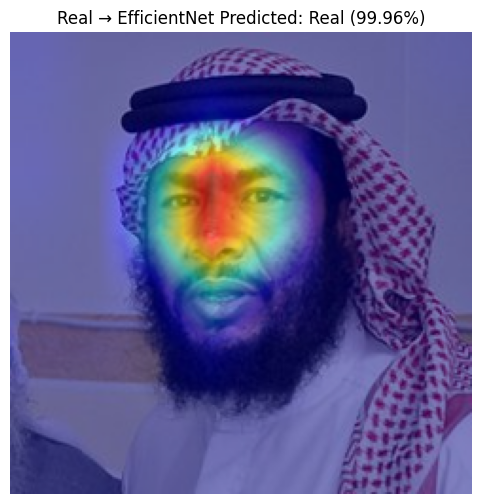

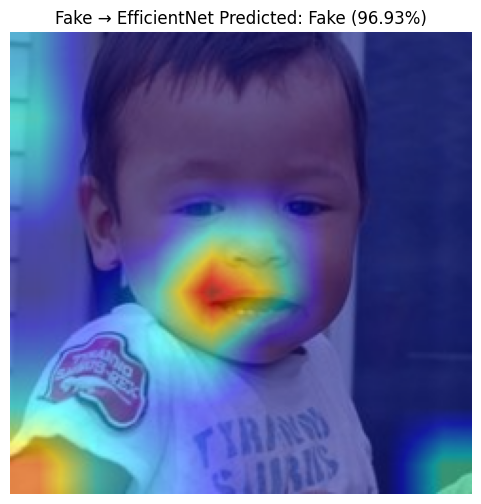

In [ ]:
# Define base directory
base_dir = "/content/drive/MyDrive/"

# Load metadata
metadata = joblib.load(os.path.join(base_dir, "UE/Thesis/model/EfficientNet_metadata.pkl"))
class_names = metadata.get("class_names", ["Fake", "Real"])
input_size = metadata.get("input_size", (244, 244))

# Load Xception model and weights
model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=len(class_names))
weights_path = os.path.join(base_dir, "UE/Thesis/model/EfficientNet_weights.pth")
model.load_state_dict(torch.load(weights_path, map_location="cpu"))
model.eval()

# Set the target layer for Grad-CAM
# target_layer = model.conv4.pointwise  # Final convolutional block of Xception
# target_layer = model.blocks[-1].bn2
target_layer = model.conv_head

# Define image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Function to load and preprocess image
def load_image(path):
    image = Image.open(path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)
    image_np = np.array(image.resize(input_size)) / 255.0
    return image_tensor, image_np

# Apply Grad-CAM and return heatmap
def apply_gradcam(model, image_tensor, image_np, target_layer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image_tensor = image_tensor.to(device)

    # with GradCAM(model=model, target_layers=[target_layer], device=device) as cam:
    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=image_tensor)[0]
        visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
        return visualization

# Set image paths (update with your own test images)
image_paths = {
    "Real": os.path.join(base_dir, "datasets/deepfake/real_0.jpg"),
    "Fake": os.path.join(base_dir, "datasets/deepfake/fake_0.jpg")
}

# Run inference and Grad-CAM visualization for each image
for label, path in image_paths.items():
    input_tensor, input_np = load_image(path)

    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        pred_class = class_names[pred_idx]
        prob = torch.nn.functional.softmax(output, dim=1)[0, pred_idx].item()

    visualization = apply_gradcam(model, input_tensor, input_np, target_layer)

    # Display the Grad-CAM result
    plt.figure(figsize=(6, 6))
    plt.imshow(visualization)
    plt.title(f"{label} → EfficientNet Predicted: {pred_class} ({prob:.2%})")
    plt.axis("off")
    plt.savefig(os.path.join(base_dir, f"UE/Thesis/EfficientNet_GradCAM_{label}.pdf"), format='pdf')

    plt.show()
    plt.close()


# Attention Rollout (ViT) - TEST

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


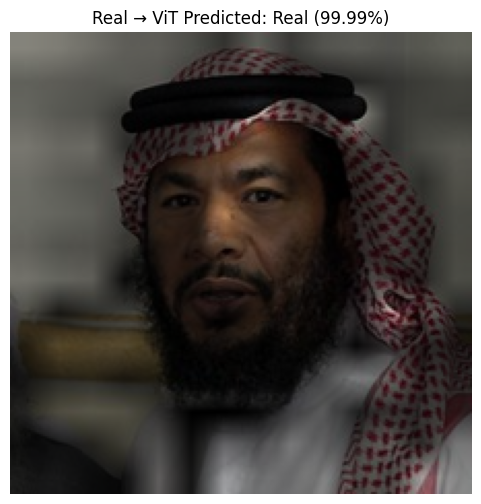

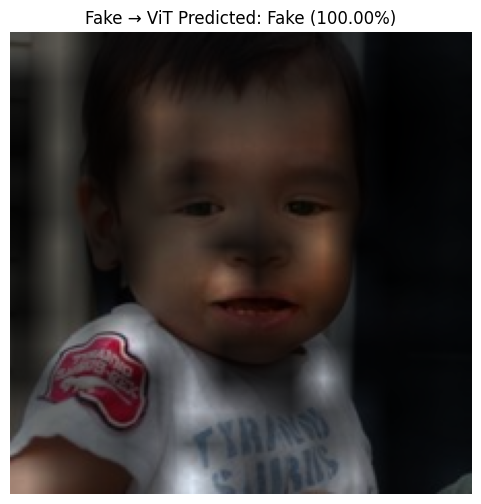

In [ ]:
# Set base directory
base_dir = "/content/drive/MyDrive/"

# Load metadata
metadata = joblib.load(os.path.join(base_dir, "UE/Thesis/model/ViT_metadata.pkl"))
class_names = metadata.get("class_names", ["Fake", "Real"])
input_size = metadata.get("input_size", (224, 224))

# Load ViT model and apply saved weights
model = ViTForImageClassification.from_pretrained( "google/vit-base-patch16-224", num_labels=2, ignore_mismatched_sizes=True)
weights_path = os.path.join(base_dir, "UE/Thesis/model/ViT_weights.pth")
model.load_state_dict(torch.load(weights_path, map_location="cpu"))
model.eval()

# Define preprocessing pipeline
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
# Custom transform using ViT feature extractor
class ViTTransform:
    def __call__(self, image):
        encoding = feature_extractor(images=image, return_tensors="pt")
        return encoding['pixel_values'].squeeze(0)

transform = ViTTransform()

# Load and preprocess an image
def load_image(path):
    image = Image.open(path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)
    image_np = np.array(image.resize(input_size)) / 255.0
    return image_tensor, image_np

# Compute attention rollout using CLS token
def compute_attention_rollout(model, input_tensor):
    with torch.no_grad():
        outputs = model(input_tensor, output_attentions=True)
        attentions = outputs.attentions

    attn_avg = [att.mean(dim=1) for att in attentions]
    rollout = attn_avg[0][0]
    for att in attn_avg[1:]:
        rollout = torch.matmul(att[0], rollout)

    cls_attn = rollout[0, 1:]
    return cls_attn

# Visualize attention heatmap overlay on the image
def visualize_attention_rollout(attn_map, image_np):
    h, w = 14, 14
    heatmap = attn_map.reshape(h, w).cpu().numpy()
    heatmap = cv2.resize(heatmap, (input_size[1], input_size[0]))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    overlay = (heatmap[..., None] * image_np).clip(0, 1)
    return overlay

# Set test image paths
image_paths = {
    "Real": os.path.join(base_dir, "datasets/deepfake/real_0.jpg"),
    "Fake": os.path.join(base_dir, "datasets/deepfake/fake_0.jpg")
}

# Run prediction and visualize attention for each image
for label, path in image_paths.items():
    input_tensor, image_np = load_image(path)

    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = torch.argmax(output.logits, dim=1).item()
        pred_class = class_names[pred_idx]
        prob = torch.nn.functional.softmax(output.logits, dim=1)[0, pred_idx].item()

    attn_map = compute_attention_rollout(model, input_tensor)
    overlay = visualize_attention_rollout(attn_map, image_np)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(f"{label} → ViT Predicted: {pred_class} ({prob:.2%})")
    plt.axis("off")
    plt.savefig(os.path.join(base_dir, f"UE/Thesis/ViT_AttentionRollout_{label}.pdf"), format='pdf')
    plt.show()
    plt.close()
